No gradient errors found.


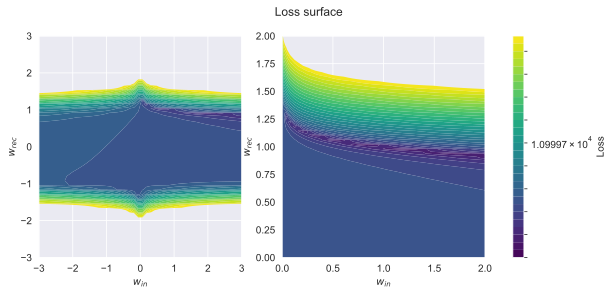

c:\Users\121731\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8342 (\N{LATIN SUBSCRIPT SMALL LETTER K}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


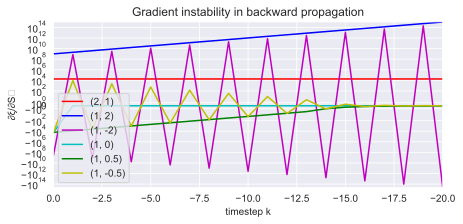

Final weights: wx = 1.1524, wRec = 0.9848


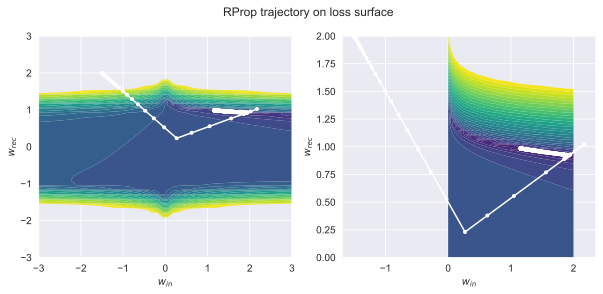

Target output: 8.0 vs Model output: 7.86


In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import LogNorm
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(1)

# Zadanie 3: 30 sekwencji po 20 kroków, wartości 0, 0.5, 1
nb_of_samples = 30
sequence_len = 20
X = np.round(np.random.rand(nb_of_samples, sequence_len) * 2) / 2
t = np.sum(X, axis=1)

# Forward i backward

def update_state(xk, sk, wx, wRec):
    return xk * wx + sk * wRec

def forward_states(X, wx, wRec):
    S = np.zeros((X.shape[0], X.shape[1] + 1))
    for k in range(X.shape[1]):
        S[:, k + 1] = update_state(X[:, k], S[:, k], wx, wRec)
    return S

def loss(y, t):
    return np.mean((t - y) ** 2)

def output_gradient(y, t):
    return 2.0 * (y - t)

def backward_gradient(X, S, grad_out, wRec):
    grad_over_time = np.zeros((X.shape[0], X.shape[1] + 1))
    grad_over_time[:, -1] = grad_out
    wx_grad = 0
    wRec_grad = 0
    for k in range(X.shape[1], 0, -1):
        wx_grad += np.sum(np.mean(grad_over_time[:, k] * X[:, k - 1], axis=0))
        wRec_grad += np.sum(np.mean(grad_over_time[:, k] * S[:, k - 1], axis=0))
        grad_over_time[:, k - 1] = grad_over_time[:, k] * wRec
    return (wx_grad, wRec_grad), grad_over_time

# Gradient checking
params = [1.2, 1.2]
eps = 1e-7
S = forward_states(X, params[0], params[1])
grad_out = output_gradient(S[:, -1], t)
backprop_grads, _ = backward_gradient(X, S, grad_out, params[1])

for p_idx, _ in enumerate(params):
    grad_backprop = backprop_grads[p_idx]
    params[p_idx] += eps
    plus_loss = loss(forward_states(X, params[0], params[1])[:, -1], t)
    params[p_idx] -= 2 * eps
    min_loss = loss(forward_states(X, params[0], params[1])[:, -1], t)
    params[p_idx] += eps
    grad_num = (plus_loss - min_loss) / (2 * eps)
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError(
            f"Gradient mismatch: numerical={grad_num:.6f}, backprop={grad_backprop:.6f}"
        )
print("No gradient errors found.")

# Wizualizacja powierzchni straty i gradientów

def get_loss_surface(w1_low, w1_high, w2_low, w2_high, nb_of_ws, loss_func):
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)
    ws1, ws2 = np.meshgrid(w1, w2)
    loss_ws = np.zeros((nb_of_ws, nb_of_ws))
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            loss_ws[i, j] = loss_func(ws1[i, j], ws2[i, j])
    return ws1, ws2, loss_ws

def plot_surface(ax, ws1, ws2, loss_ws):
    surf = ax.contourf(ws1, ws2, loss_ws + 1, levels=np.logspace(-0.2, 8, 30), cmap=cm.viridis, norm=LogNorm())
    ax.set_xlabel('$w_{in}$')
    ax.set_ylabel('$w_{rec}$')
    return surf

def get_loss_surface_figure(loss_func):
    fig = plt.figure(figsize=(10, 4))
    ax_1 = fig.add_subplot(1, 2, 1)
    ws1, ws2, loss_ws = get_loss_surface(-3, 3, -3, 3, 50, loss_func)
    surf = plot_surface(ax_1, ws1, ws2, loss_ws)
    ax_2 = fig.add_subplot(1, 2, 2)
    ws1, ws2, loss_ws = get_loss_surface(0, 2, 0, 2, 50, loss_func)
    surf = plot_surface(ax_2, ws1, ws2, loss_ws)
    fig.colorbar(surf, ax=[ax_1, ax_2], label='Loss')
    fig.suptitle("Loss surface")
    plt.show()

get_loss_surface_figure(lambda w1, w2: loss(forward_states(X, w1, w2)[:, -1], t))

# Gradient w czasie

def get_grad_over_time(wx, wRec):
    S = forward_states(X, wx, wRec)
    grad_out = output_gradient(S[:, -1], t).sum()
    _, grad_over_time = backward_gradient(X, S, grad_out, wRec)
    return grad_over_time

def plot_gradient_over_time(points):
    fig = plt.figure(figsize=(7, 3))
    ax = plt.subplot(111)
    for wx, wRec, c in points:
        grad_over_time = get_grad_over_time(wx, wRec)
        x = np.arange(-grad_over_time.shape[1]+1, 1, 1)
        plt.plot(x, np.sum(grad_over_time, axis=0), c+'-', label=f'({wx}, {wRec})')
    plt.xlim(0, -grad_over_time.shape[1]+1)
    plt.yscale('symlog')
    plt.xlabel('timestep k')
    plt.ylabel('∂ξ/∂Sₖ')
    plt.title('Gradient instability in backward propagation')
    plt.legend()
    plt.show()

points = [(2,1,'r'), (1,2,'b'), (1,-2,'m'), (1,0,'c'), (1,0.5,'g'), (1,-0.5,'y')]
plot_gradient_over_time(points)

# Rprop

def update_rprop(X, t, W, W_prev_sign, W_delta, eta_p, eta_n):
    S = forward_states(X, W[0], W[1])
    grad_out = output_gradient(S[:, -1], t)
    W_grads, _ = backward_gradient(X, S, grad_out, W[1])
    W_sign = np.sign(W_grads)
    for i in range(len(W)):
        if W_sign[i] == W_prev_sign[i]:
            W_delta[i] *= eta_p
        else:
            W_delta[i] *= eta_n
    return W_delta, W_sign

eta_p = 1.2
eta_n = 0.5
W = [-1.5, 2.0]
W_delta = [0.001, 0.001]
W_sign = [0, 0]
ls_of_ws = [(W[0], W[1])]

for i in range(500):
    W_delta, W_sign = update_rprop(X, t, W, W_sign, W_delta, eta_p, eta_n)
    for j in range(len(W)):
        W[j] -= W_sign[j] * W_delta[j]
    ls_of_ws.append((W[0], W[1]))

print(f'Final weights: wx = {W[0]:.4f}, wRec = {W[1]:.4f}')

# Wizualizacja trajektorii

def plot_optimisation(ls_of_ws, loss_func):
    ws1, ws2 = zip(*ls_of_ws)
    fig = plt.figure(figsize=(10, 4))
    ax_1 = fig.add_subplot(1, 2, 1)
    ws1_1, ws2_1, loss_ws_1 = get_loss_surface(-3, 3, -3, 3, 50, loss_func)
    surf_1 = plot_surface(ax_1, ws1_1, ws2_1, loss_ws_1)
    ax_1.plot(ws1, ws2, 'wo-', markersize=3)
    ax_2 = fig.add_subplot(1, 2, 2)
    ws1_2, ws2_2, loss_ws_2 = get_loss_surface(0, 2, 0, 2, 50, loss_func)
    surf_2 = plot_surface(ax_2, ws1_2, ws2_2, loss_ws_2)
    ax_2.plot(ws1, ws2, 'wo-', markersize=3)
    plt.suptitle("RProp trajectory on loss surface")
    plt.show()

plot_optimisation(ls_of_ws, lambda w1, w2: loss(forward_states(X, w1, w2)[:, -1], t))

# Test końcowy
test_inpt = np.asmatrix([[1, 0.5, 0, 1, 0, 0, 0.5, 0.5, 1, 0, 0, 0.5, 0, 0.5, 1, 1, 0.5, 0, 0, 0]])
test_outpt = forward_states(test_inpt, W[0], W[1])[:, -1]
sum_test_inpt = test_inpt.sum()
print(f'Target output: {sum_test_inpt:.1f} vs Model output: {test_outpt[0]:.2f}')
